# Loan Payback Prediction

This notebook aims to predict whether a loan will be paid back based on various borrower and loan characteristics. It explores both traditional machine learning models and a deep learning approach.


### 1. Data Loading and Initial Inspection

This section loads the training and testing datasets, and performs an initial inspection of the data, including displaying the first few rows, checking data types, and examining the distribution of the target variable.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

df = pd.read_csv('train.csv', index_col='id')
df_test = pd.read_csv('test.csv', index_col='id')
y = df['loan_paid_back']
X = df.drop('loan_paid_back', axis=1)
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


### 2. Exploratory Data Analysis (EDA)

Here, we visualize the distributions of categorical and numerical features using count plots, histograms, and box plots to understand their characteristics and identify potential issues like outliers.

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, OrdinalEncoder

y.value_counts()

,count
loan_paid_back,
1.0,474494
0.0,119500


In [ ]:
y = y.astype('int64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 58.9+ MB


### 3. Feature Preprocessing

This section handles categorical feature encoding using OrdinalEncoder, checks for skewness in numerical features, identifies correlations between features, and applies outlier handling to numerical columns. It also creates a PCA-transformed version of the data for comparison.

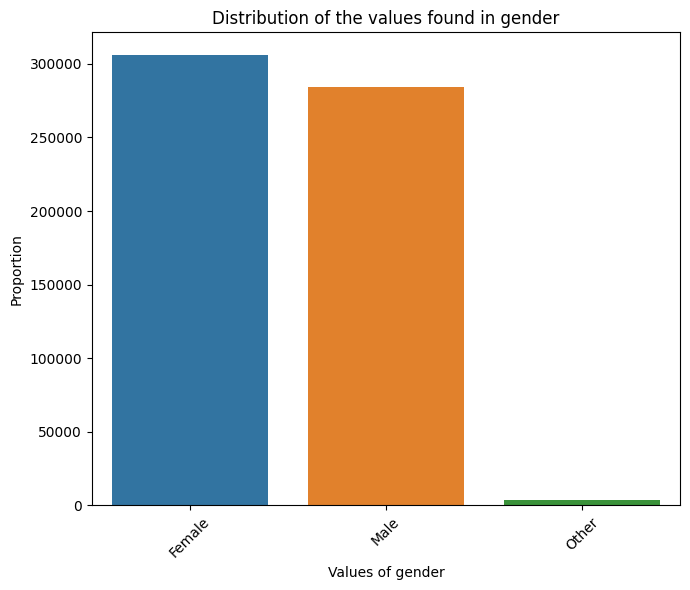

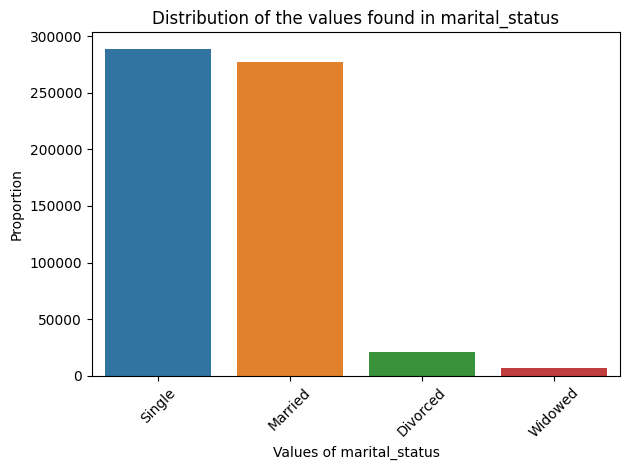

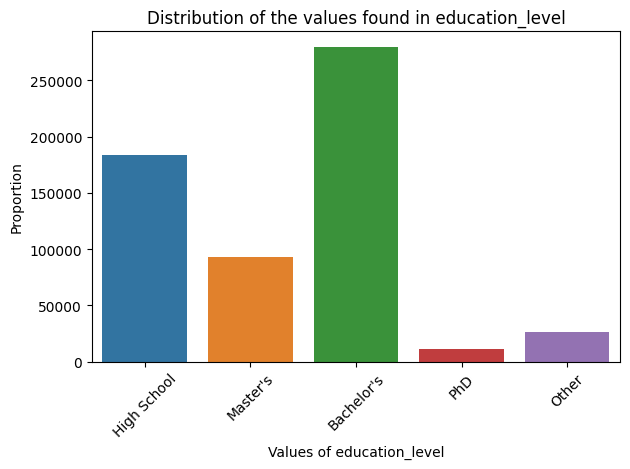

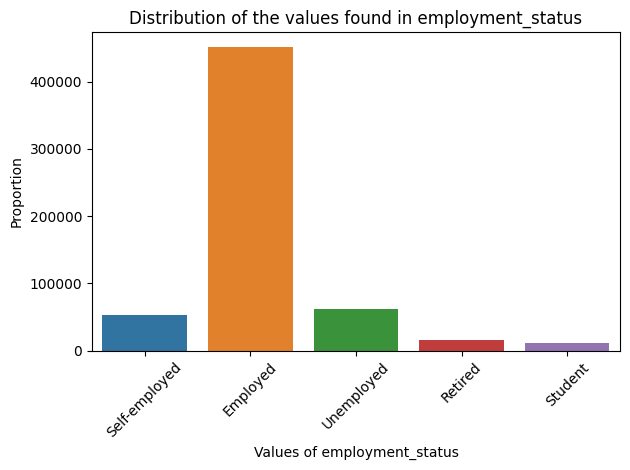

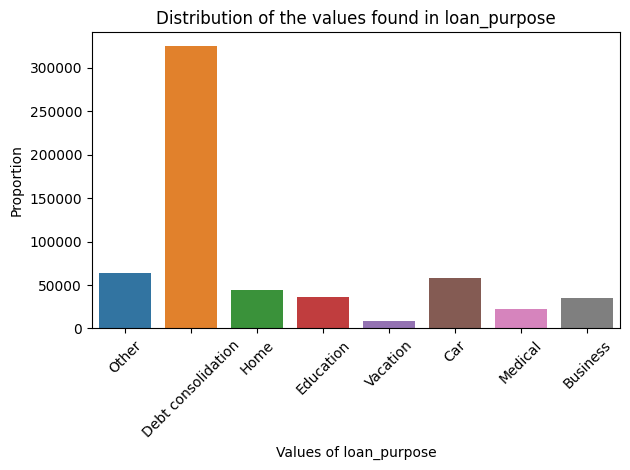

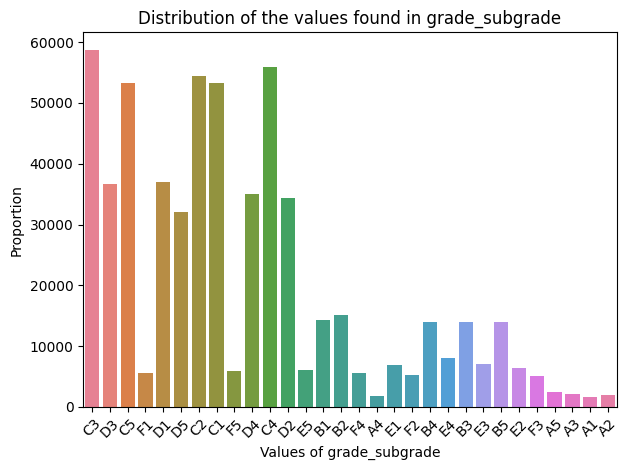

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

num_features = X.select_dtypes(include=['number']).columns
cat_features = X.select_dtypes(include=['object']).columns

plt.figure(figsize=(7,6))
for feature in cat_features:
  sns.countplot(data=X, x=feature, hue=feature)
  plt.title(f'Distribution of the values found in {feature}')
  plt.xlabel(f'Values of {feature}')
  plt.ylabel('Proportion')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

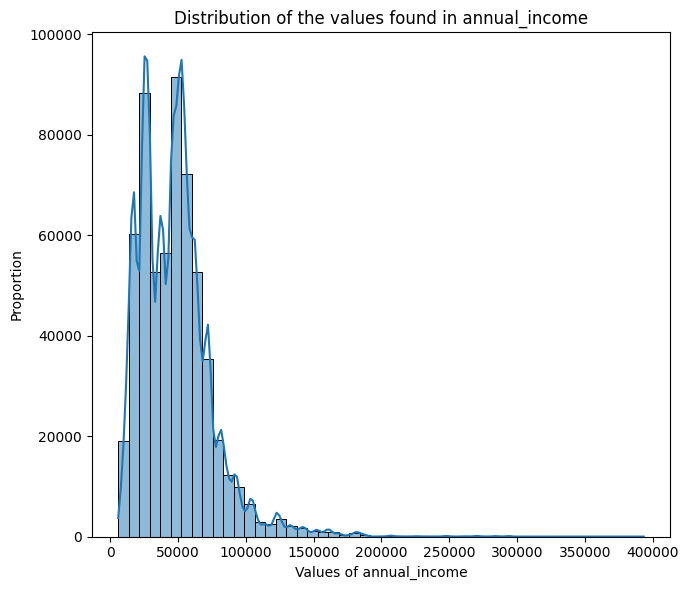

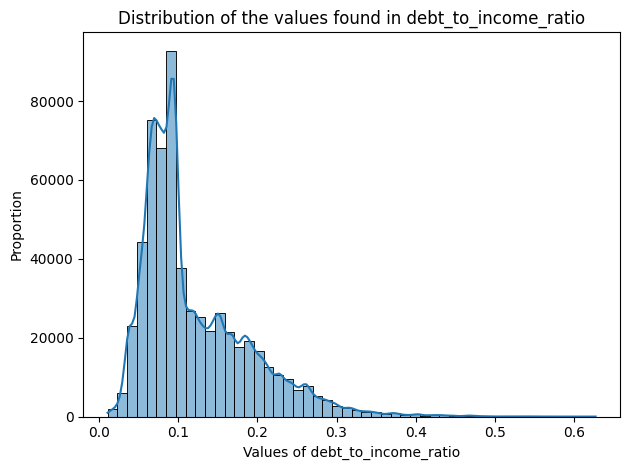

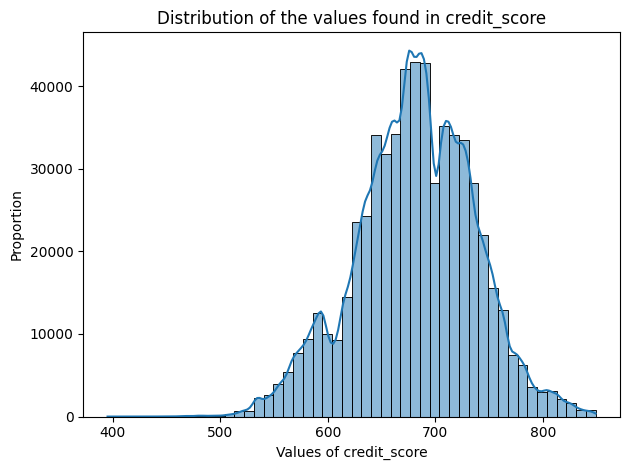

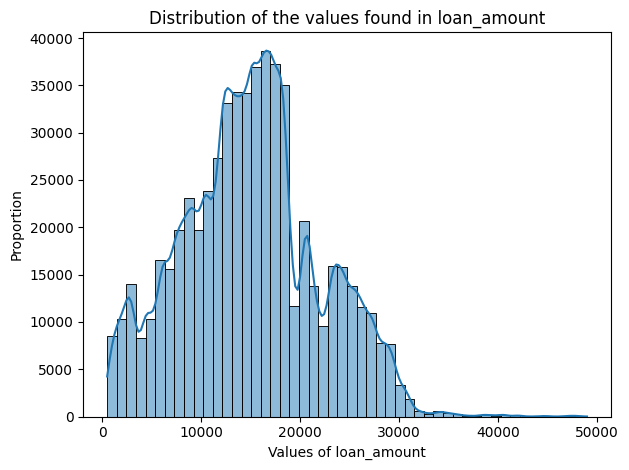

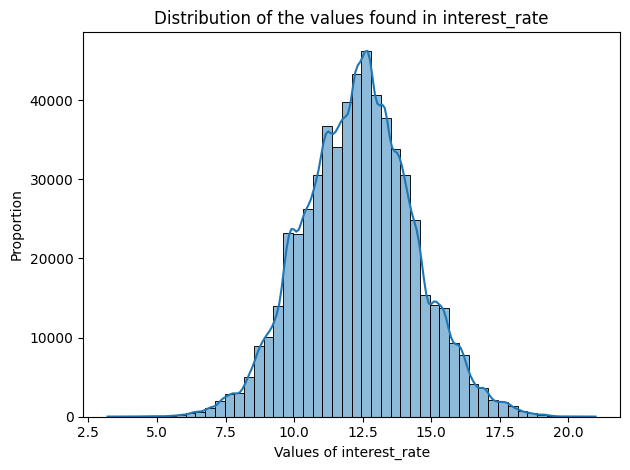

In [ ]:
plt.figure(figsize=(7,6))
for feature in num_features:
  sns.histplot(data=X, x=feature, kde=True, bins=50)
  plt.title(f'Distribution of the values found in {feature}')
  plt.xlabel(f'Values of {feature}')
  plt.ylabel('Proportion')
  plt.tight_layout()
  plt.show()

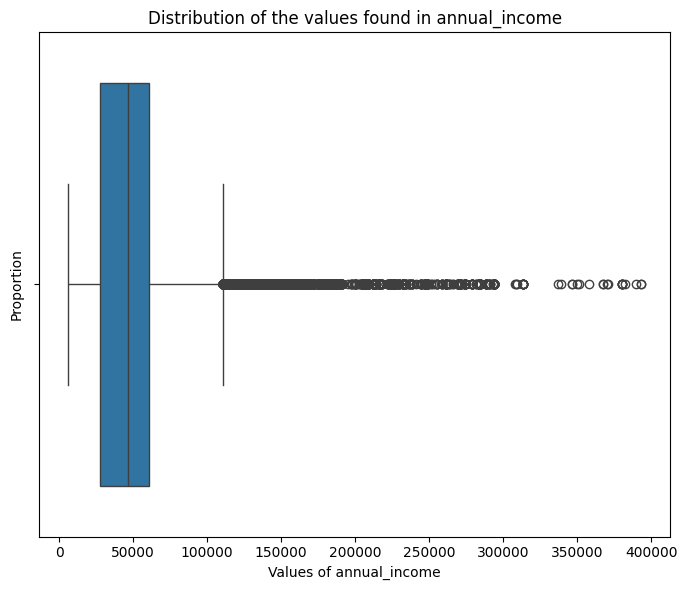

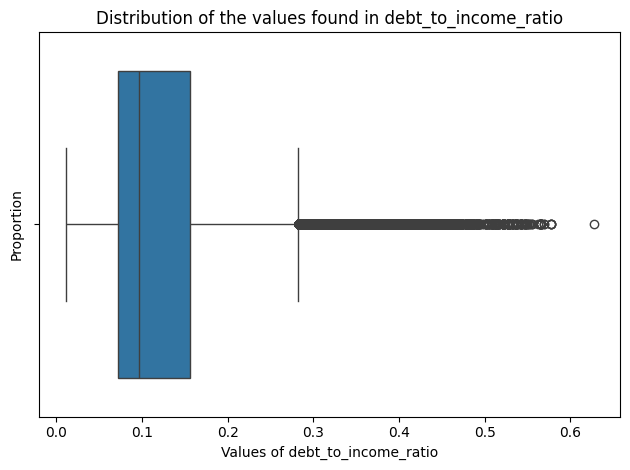

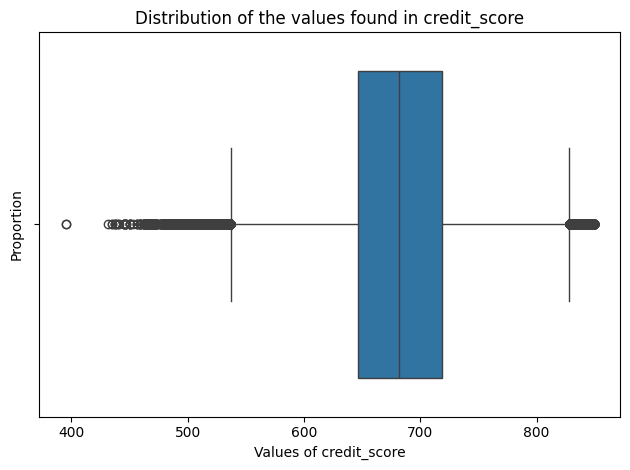

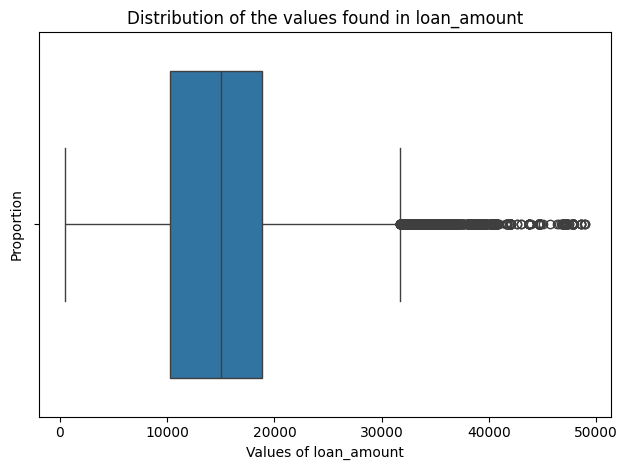

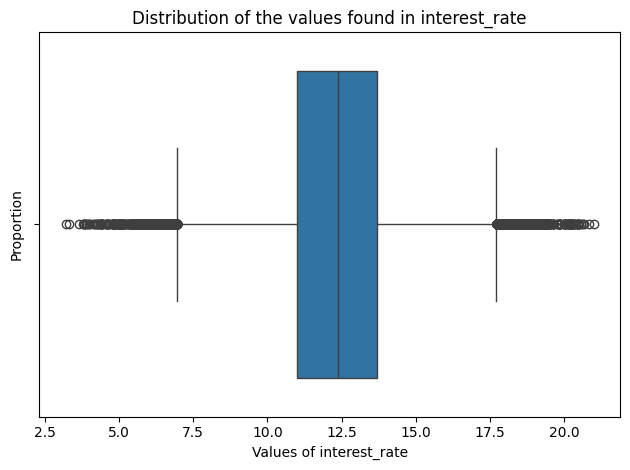

In [ ]:
plt.figure(figsize=(7,6))
for feature in num_features:
  sns.boxplot(data=X, x=feature)
  plt.title(f'Distribution of the values found in {feature}')
  plt.xlabel(f'Values of {feature}')
  plt.ylabel('Proportion')
  plt.tight_layout()
  plt.show()

# Outliers to be handled!! -> RobustScaler

In [ ]:
oe = OrdinalEncoder()
X[cat_features] = oe.fit_transform(X[cat_features]).astype('int')
for feature in cat_features:
  print(X[feature].value_counts())

gender
0    306175
1    284091
2      3728
Name: count, dtype: int64
marital_status
2    288843
1    277239
0     21312
3      6600
Name: count, dtype: int64
education_level
0    279606
1    183592
2     93097
3     26677
4     11022
Name: count, dtype: int64
employment_status
0    450645
4     62485
2     52480
1     16453
3     11931
Name: count, dtype: int64
loan_purpose
2    324695
6     63874
1     58108
4     44118
3     36641
0     35303
5     22806
7      8449
Name: count, dtype: int64
grade_subgrade
12    58695
13    55957
11    54443
10    53363
14    53317
15    37029
17    36694
18    35097
16    34432
19    32101
6     15167
5     14344
9     13937
7     13926
8     13877
23     8036
22     7075
20     6891
21     6372
24     6084
29     5947
28     5535
25     5534
26     5203
27     5082
4      2471
2      2066
1      2018
3      1701
0      1600
Name: count, dtype: int64


In [ ]:
skewness = X.skew()
skewed_columns = skewness[abs(skewness) > 1]
print('Skewed Columns')
print(skewed_columns.sort_values(ascending=False))

Skewed Columns
annual_income           1.719509
employment_status       1.706852
debt_to_income_ratio    1.406680
education_level         1.119036
dtype: float64


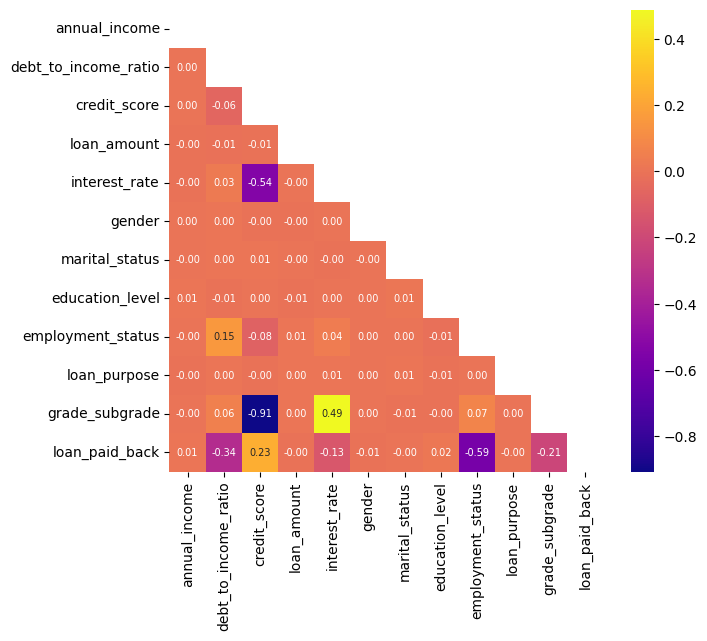

In [ ]:
# Checking correlations

combined_df = pd.concat([X, y], axis=1)
corr_combined_df = combined_df.corr()

mask = np.triu(corr_combined_df)

plt.figure(figsize=(7,6))
sns.heatmap(
    data=corr_combined_df,
    cmap='plasma',
    annot=True,
    cbar=True,
    mask=mask,
    annot_kws={'size': 7},
    fmt='.2f'
)
plt.show()

In [ ]:
# Handling outliers and skewed distribution

for feature in num_features:
  Q1 = X[feature].quantile(q=0.25)
  Q3 = X[feature].quantile(q=0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR

  X[feature] = np.where(X[feature] < lower, lower,
                        np.where(X[feature] > upper, upper, X[feature]))

In [ ]:
X_copy = X.copy()
pca = PCA(n_components=9, svd_solver='covariance_eigh')
X_copy = pca.fit(X_copy).transform(X_copy)

### 4. Training ML Models

This part focuses on training and evaluating traditional machine learning models. It starts by splitting the data into training and validation sets. Then, it trains a LinearSVC model with and without PCA-transformed data, and evaluates their performance using ROC curves. Additionally, an ensemble method (VotingClassifier) with a HistGradientBoostingClassifier is trained and evaluated.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=42)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_copy, y, test_size=.3, random_state=42)

linearSVC = LinearSVC(random_state=42, class_weight={0: 4, 1:1} )
linearSVC.fit(X_train, y_train)

linearSVC_pca = LinearSVC(random_state=42, class_weight={0: 4, 1:1})
linearSVC_pca.fit(X_train_pca, y_train_pca)

y_preds = linearSVC.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_preds)
print(f'False Positive Rate of the model trained without prior PCA: ', fpr)
print(f'True Positive Rate of the model trained without prior PCA: ', tpr)
print(f'Threshold of the model trained without prior PCA: ', thresholds)

print('-'*50)

y_preds_pca = linearSVC_pca.predict(X_val_pca)
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_val_pca, y_preds_pca)
print(f'False Positive Rate of the model trained with prior PCA: ', fpr_pca)
print(f'True Positive Rate of the model trained with prior PCA: ', tpr_pca)
print(f'Threshold of the model trained with prior PCA: ', thresholds_pca)

False Positive Rate of the model trained without prior PCA:  [0.         0.23101643 1.        ]
True Positive Rate of the model trained without prior PCA:  [0.         0.85448481 1.        ]
Threshold of the model trained without prior PCA:  [inf  1.  0.]
--------------------------------------------------
False Positive Rate of the model trained with prior PCA:  [0.         0.33770119 1.        ]
True Positive Rate of the model trained with prior PCA:  [0.         0.85302107 1.        ]
Threshold of the model trained with prior PCA:  [inf  1.  0.]


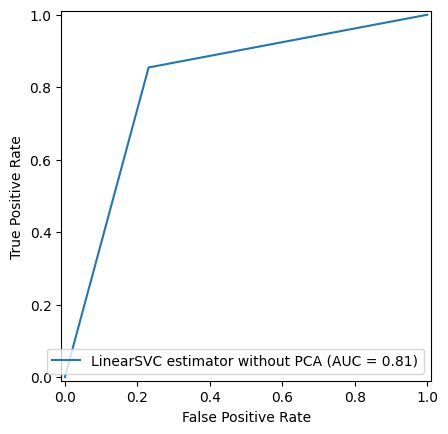

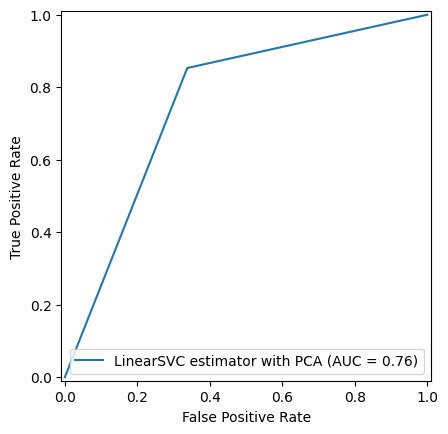

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

roc_auc = metrics.auc(fpr, tpr)
roc_auc_pca = metrics.auc(fpr_pca, tpr_pca)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LinearSVC estimator without PCA')
display_pca = metrics.RocCurveDisplay(fpr=fpr_pca, tpr=tpr_pca, roc_auc=roc_auc_pca,estimator_name='LinearSVC estimator with PCA')

display.plot()
display_pca.plot()

plt.show()

In [ ]:
hsbc = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=120,
    random_state=42,
    class_weight={0: 4, 1:1}
)

vc_soft = VotingClassifier(
    estimators=[('linearSVC', linearSVC), ('hsbc', hsbc)],
    voting='soft',
    verbose=1
)

vc_hard = VotingClassifier(
    estimators=[('linearSVC', linearSVC), ('hsbc', hsbc)],
    voting='hard',
    verbose=1
)

# vc_soft.fit(X_train, y_train)
# y_prediction_soft = vc_soft.predict(X_val)

vc_hard.fit(X_train, y_train)
y_prediction_hard = vc_hard.predict(X_val)

# fpr_soft, tpr_soft, thresholds_soft = roc_curve(y_val, y_prediction_soft)
# print(f'False Positive Rate of the VotingClassifier with soft voting: ', fpr_soft)
# print(f'True Positive Rate of the VotingClassifier with soft voting: ', tpr_soft)
# print(f'Threshold of the VotingClassifier with soft voting: ', thresholds_soft)

print('-'*100)

fpr_hard, tpr_hard, thresholds_hard = roc_curve(y_val, y_prediction_hard)
print(f'False Positive Rate of the VotingClassifier with hard voting: ', fpr_hard)
print(f'True Positive Rate of the VotingClassifier with hard voting: ', tpr_hard)
print(f'Threshold of the VotingClassifier with hard voting: ', thresholds_hard)

[Voting] ................ (1 of 2) Processing linearSVC, total=  21.0s
[Voting] ..................... (2 of 2) Processing hsbc, total=  21.2s
----------------------------------------------------------------------------------------------------
False Positive Rate of the VotingClassifier with hard voting:  [0.        0.1936726 1.       ]
True Positive Rate of the VotingClassifier with hard voting:  [0.         0.82619527 1.        ]
Threshold of the VotingClassifier with hard voting:  [inf  1.  0.]


In [ ]:
hsbc.fit(X_train, y_train)

hsbc_preds = hsbc.predict(X_val)
fpr_hsbc, tpr_hsbc, thresholds_hsbc = roc_curve(y_val, hsbc_preds)
print(f'False Positive Rate of the HistGradientBoostingClassifier: ', fpr_hsbc)
print(f'True Positive Rate of the HistGradientBoostingClassifier: ', tpr_hsbc)
print(f'Threshold of the HistGradientBoostingClassifier: ', thresholds_hsbc)

False Positive Rate of the HistGradientBoostingClassifier:  [0.         0.21691553 1.        ]
True Positive Rate of the HistGradientBoostingClassifier:  [0.        0.8785098 1.       ]
Threshold of the HistGradientBoostingClassifier:  [inf  1.  0.]


### 5. Deep Learning Model

This section sets up and trains a deep learning model using PyTorch. It defines a `Config` class for hyperparameters, `Transform` class for data preprocessing within the deep learning pipeline, and `ResidualBlock` and `MLPRegressor` classes for the neural network architecture. The model is trained using K-fold cross-validation, and metrics are logged with CometML.

In [ ]:
pip install comet_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from itertools import combinations
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import torch
from comet_ml import start
from comet_ml.integration.pytorch import log_model
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
warnings.filterwarnings("ignore")

In [ ]:
API_KEY = 'Your API Key'
experiment = start(
  api_key=API_KEY,
  project_name="loan-payback-dl",
  workspace="dreadnought0073"
)

In [ ]:
class Config:
    target = 'loan_paid_back'
    train = pd.read_csv('train.csv', index_col='id')
    test = pd.read_csv('test.csv', index_col='id')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    state = 42
    n_splits = 2
    early_stop = 20
    metric = 'roc_auc'
    task_type = "classification"
    task_is_regression = task_type == 'regression'
    outliers = True
    log_trf = False
    feature_eng = False
    missing = False
    training = True

In [ ]:
def roc_auc(y_true, y_preds):
  return roc_auc_score(y_true, y_preds)

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
class Transform(Config):
    def __init__(self):
        super().__init__()

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(include=['number']).columns.tolist()

        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'category']).columns.tolist()

        if self.missing:
          self.missing_values()
        if self.feature_eng:
          self.train = self.new_features(self.train)
          self.test = self.new_features(self.test)
        if self.outliers:
          self.train = self.remove_outliers(self.train)
          self.test = self.remove_outliers(self.test)
        if self.log_trf:
          self.log_transformation()
        self.encode()

    def __call__(self):
        self.y = self.train[self.target]

        self.X = self.train.drop(self.target, axis=1)

        self.X_enc = self.train_enc.drop(self.target, axis=1)

        return self.X, self.X_enc, self.y, self.test, self.test_enc, self.cat_features, self.num_features

    def encode(self):
        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()

        data = pd.concat([self.train_enc, self.test_enc], axis=0)
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')
        scaler = RobustScaler()
        data[self.num_features] = scaler.fit_transform(data[self.num_features])
        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)

    def remove_outliers(self, data):
      for feature in self.num_features:
        Q1 = data[feature].quantile(q=0.25)
        Q3 = data[feature].quantile(q=0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR

        data[feature] = np.where(data[feature] < lower, lower,
                              np.where(data[feature] > upper, upper, data[feature]))

      return data

    def new_features(self, data):
        for c1, c2 in list(combinations(self.num_features, 2)):
            data[f"{c1}_{c2}"] = data[c1] * data[c2]
            data[f'{c1}_div_{c2}'] = data[c1] / (data[c2] + 1e-6)
        for c in self.num_features:
            data[f"{c}_quartile"] = pd.cut(data[c], bins=4, labels=False, include_lowest=True)
            data[f"{c}_decile"] = pd.cut(data[c], bins=10, labels=False, include_lowest=True)
        return data

    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target])

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(out_features, out_features)
        self.fc4 = nn.Linear(out_features, out_features)
        self.bn2 = nn.BatchNorm1d(out_features)
        self.gelu = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.shortcut = nn.Identity() if in_features == out_features else nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.fc(x)
        out = self.fc2(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.bn2(out)
        out = self.gelu(out)
        out = self.drop(out)
        res = self.shortcut(x)
        return self.gelu(out + res)


class MLPRegressor(nn.Module):
    def __init__(self, in_features, hidden_dims, dropout):
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden_dims:
          layers.append(ResidualBlock(prev, h, dropout))
          prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)

In [ ]:
def train_one_fold(X_tr, y_tr, X_va, y_va, count_values, params, epochs, batch_size, patience):
    ds_tr = TensorDataset(torch.from_numpy(X_tr).float(), torch.from_numpy(y_tr).float())
    ds_va = TensorDataset(torch.from_numpy(X_va).float(), torch.from_numpy(y_va).float())

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2, persistent_workers=True)

    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=1, persistent_workers=True)

    model = MLPRegressor(
        in_features=X_tr.shape[1],
        hidden_dims=params['hidden_dims'],
        dropout=params['dropout']
    ).to(Config.device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    pos_weight_value = torch.tensor(count_values[0] / count_values[1], dtype=torch.float32).to(Config.device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=max(patience // 4, 10), factor=0.5
    )

    best_loss = float('inf')
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in dl_tr:
          xb, yb = xb.to(Config.device), yb.to(Config.device)
          optimizer.zero_grad()
          preds = model(xb)
          loss = criterion(preds, yb)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * xb.size(0)

        train_loss /= len(ds_tr)
        experiment.log_metric(f"Epoch {epoch+1} train loss", train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
          for xb, yb in dl_va:
            xb, yb = xb.to(Config.device), yb.to(Config.device)
            preds_model = model(xb)
            val_loss += criterion(preds_model, yb).item() * xb.size(0)
        val_loss /= len(ds_va)
        scheduler.step(val_loss)
        experiment.log_metric(f"Epoch {epoch+1} validation loss", val_loss)
        if (epoch + 1) % patience == 0:
          print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_loss:
          best_loss = val_loss
          best_state = {k: v.cpu() for k, v in model.state_dict().items()}
          no_improve = 0
        else:
          no_improve += 1
          if no_improve >= patience:
              print(f"Early stopping at epoch {epoch+1}, best val loss = {best_loss:.6f}")
              break

    model.load_state_dict({k: v.to(Config.device) for k,v in best_state.items()})
    model.eval()
    with torch.no_grad():
      va_out_logits = model(torch.from_numpy(X_va).float().to(Config.device)).cpu().numpy()
      va_out_probs = torch.sigmoid(torch.from_numpy(va_out_logits)).numpy()

    metric_roc_auc = roc_auc(y_va, va_out_probs)
    experiment.log_metric("Validation ROC AUC score", metric_roc_auc)

    return va_out_probs, metric_roc_auc, model

In [ ]:
def fit_predict_cv(X, y, X_test, seed=42):
    set_seed(seed)

    count_values = y.value_counts()
    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(np.float32)
    X_test_np = X_test.values.astype(np.float32)

    kf = KFold(n_splits=Config.n_splits, shuffle=True, random_state=seed)

    oof = np.zeros(len(X_np), dtype=np.float32)

    test_pred_logits = np.zeros(len(X_test_np), dtype=np.float32)

    params = {
        'hidden_dims': [1024, 512, 256, 128],
        'dropout': 0.4,
        'lr': 1e-2,
        'weight_decay': 1e-3
    }

    experiment.log_parameters(params)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np, y_np)):
      print(f'Going through Fold {fold +1}')
      X_train_fold, y_train_fold = X_np[train_idx], y_np[train_idx]
      X_val_fold, y_val_fold = X_np[val_idx], y_np[val_idx]
      va_out_probs, fold_roc_auc, model = train_one_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, count_values, params, epochs=2000, batch_size=768, patience=Config.early_stop)

      log_model(experiment, model=model, model_name="LoanPaybackPredictor")

      oof[val_idx] = va_out_probs
      with torch.no_grad():
        test_pred_logits += model(torch.from_numpy(X_test_np).float().to(Config.device)).cpu().numpy() / Config.n_splits

      print(f"Fold {fold+1} ROC AUC Score: {fold_roc_auc:.5f}")
      experiment.log_metric(f"Fold_{fold+1}_roc_auc", fold_roc_auc)

    test_pred_probs = torch.sigmoid(torch.from_numpy(test_pred_logits)).numpy()

    oof_roc_auc = roc_auc_score(y_np, oof)
    print(f"OOF ROC AUC Score: {oof_roc_auc:.5f}")
    experiment.log_metric("oof_roc_auc", oof_roc_auc)

    return oof, test_pred_probs, oof_roc_auc


def main():
    t = Transform()

    X, X_enc, y, test, test_enc, cat_features, num_features = t()

    oof_preds, test_preds, oof_roc_auc = fit_predict_cv(
        X_enc,
        y,
        test_enc,
        seed=Config.state
    )

In [ ]:
if __name__ == "__main__":
  main()

In [ ]:
experiment.end()